In [46]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
font={
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
    "font.size": 16,
}
plt.rcParams.update(font)

base_dir = os.path.join(os.getcwd(), "resources/")

In [47]:
# simulation settings
sr_etc = 200
etc_time_resolution = 1/sr_etc
speed_of_sound = 337
att_dB = 2/1000
freqcy = 500

In [48]:
IR_measured=pf.io.read_audio(base_dir+'raw.wav')

latency = int(2300)-int(2*etc_time_resolution*IR_measured.sampling_rate)

IR_measured = pf.Signal(data=IR_measured.time[0,latency:],
                        sampling_rate=IR_measured.sampling_rate)

print(IR_measured.signal_type)

IR_filtered = pf.dsp.filter.fractional_octave_bands(IR_measured,
                                                    3,
                                                    frequency_range=(20,20000))
center_freqs = pf.dsp.filter.fractional_octave_frequencies(3,(20,20000))


energy


c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\dsp\filter\fractional_octaves.py:252: UserWarning: The upper frequency limit 22387.2 Hz is above the Nyquist frequency. Using a highpass filter instead of a bandpass.
  sos = _coefficients_fractional_octave_bands(


In [49]:
# generate measured etc from IR data
sr_src = IR_measured.sampling_rate

duration = IR_measured.signal_length
n_etc_samples = int(duration*sr_etc)+1

etc_array = np.zeros((IR_filtered.cshape[0],n_etc_samples))

for freqbin in range(IR_filtered.cshape[0]):
    src=IR_filtered.time[freqbin,0,:]
    for i in range(src.shape[0]):
        etc_array[freqbin,int(sr_etc*i/sr_src)] += np.square(src[i])
    etc_level = np.sum(np.square(src[2:int(0.1*sr_src)]))/(int(0.1*sr_src)-2)

etc_array = (etc_array-etc_level)*etc_time_resolution

freqbin =np.where(center_freqs[0]==freqcy)

etc_measurement = pf.Signal(data=etc_array[freqbin],sampling_rate=sr_etc,
                            comment="measured ETC")


1.4578231292517008


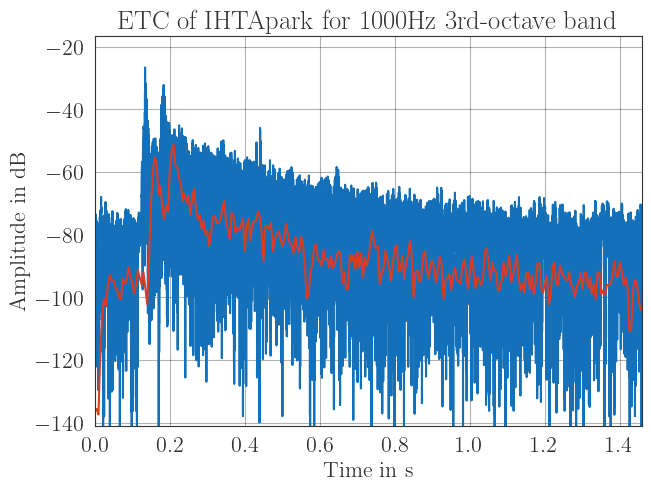

In [50]:
# visualize etc at 1000Hz
pf.plot.time(signal=IR_measured,dB=True,log_prefix=20)
pf.plot.time(signal=etc_measurement,dB=True,log_prefix=10)
plt.title("ETC of IHTApark for 1000Hz 3rd-octave band")
print(duration)

In [51]:
#radiosity object from file, whole wall-patch shabang
radi = sp.DirectionalRadiosityFast.from_file(
                filepath="resources/reduced_ihtapark.blend",
                wall_auto_assembly=False,
                geometry_identifier="Geometry",
                )

In [52]:
# set material properties
materials = np.array(["ITAs_acoustic_facade1","ITAs_acoustic_facade2",
                      "ITAs_acoustic_facade3","ITAs_acoustic_facade4",
                      "ITAs_acoustic_facade5","ITAs_acoustic_grass",
                      "ITAs_acoustic_asphalt"])
alpha = np.empty((materials.shape[0]))
sigma = np.empty((materials.shape[0]))

# for i,material in enumerate(materials): # 1000Hz
#     match material:
#         case "ITAs_acoustic_facade1":
#             alpha[i] = 0.07
#             sigma[i] = 0.8
#         case "ITAs_acoustic_facade2":
#             alpha[i] = 0.07
#             sigma[i] = 0.75
#         case "ITAs_acoustic_facade3":
#             alpha[i] = 0.04
#             sigma[i] = 0.05
#         case "ITAs_acoustic_facade4":
#             alpha[i] = 0.04
#             sigma[i] = 0.05
#         case "ITAs_acoustic_facade5":
#             alpha[i] = 0.04
#             sigma[i] = 0.05
#         case "ITAs_acoustic_grass":
#             alpha[i] = 0.39
#             sigma[i] = 0.4
#         case "ITAs_acoustic_asphalt":
#             alpha[i] = 0.015
#             sigma[i] = 0.

for i,material in enumerate(materials):
    match material:
        case "ITAs_acoustic_facade1":
            alpha[i] = 0.07
            sigma[i] = 0.61391
        case "ITAs_acoustic_facade2":
            alpha[i] = 0.07
            sigma[i] = 0.63433
        case "ITAs_acoustic_facade3":
            alpha[i] = 0.04
            sigma[i] = 0.03
        case "ITAs_acoustic_facade4":
            alpha[i] = 0.04
            sigma[i] = 0.03
        case "ITAs_acoustic_facade5":
            alpha[i] = 0.04
            sigma[i] = 0.03
        case "ITAs_acoustic_grass":
            alpha[i] = 0.28
            sigma[i] = 0.25
        case "ITAs_acoustic_asphalt":
            alpha[i] = 0.01
            sigma[i] = 0.01


C:\Users\jotag\AppData\Local\Temp\ipykernel_17004\3187184763.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  samples = pf.samplings.sph_gaussian(10)
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\samplings\samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\classes\coordinates.py:276: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order


<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

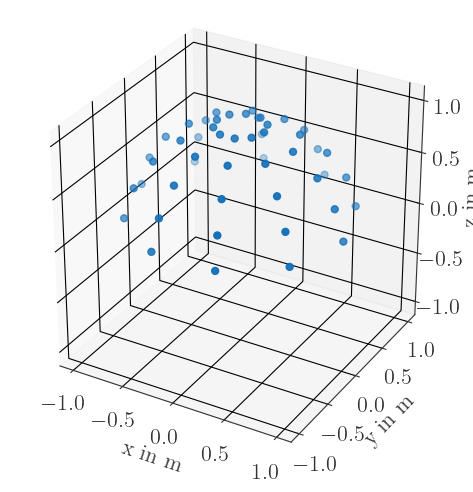

In [53]:
# set brdfs
samples = pf.samplings.sph_gaussian(10)
samples.weights*=4*np.pi/np.sum(samples.weights)
brdf_sources = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_receivers = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()

brdf_sources.show()


In [54]:
# set brdfs
frequencies = np.array([freqcy])

# set air absorption
att_Np = att_dB*.115129254

radi.set_air_attenuation(
    pf.FrequencyData(
        att_Np*np.ones_like(frequencies),
        frequencies))

for i,material in enumerate(materials):

    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(sigma[i], frequencies),
        pf.FrequencyData(alpha[i], frequencies))

    # set directional scattering data
    radi.set_wall_brdf(
        np.where(radi._walls_material==material)[0],
        brdf,
        brdf_sources,
        brdf_receivers)


C:\Users\jotag\AppData\Local\Temp\ipykernel_17004\480024987.py:21: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radi.set_wall_brdf(


In [55]:
print(np.max(radi.patches_area))
print((.025*2629.9, .025*85.71, .025*-10.967))

246.16191397441136
(65.7475, 2.14275, -0.274175)


In [56]:
# bake geometry and save
radi.bake_geometry()
#radi.write(os.path.join(base_dir,"ihtapark.far"))

In [57]:
# read
#radi=sp.DirectionalRadiosityFast.from_read(os.path.join(base_dir,"ihtapark.far"))

#model has a weird .025 scale
source = pf.Coordinates(.025*924.05, .025*-820.39, .025*310.546)

# initialize source energy
radi.init_source_energy(source)

#radi.write(os.path.join(base_dir,"ihtapark_se.far"))

In [58]:
radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=etc_time_resolution,
        etc_duration=etc_measurement.signal_length,
        max_reflection_order=50,
        recalculate=True)


In [59]:
receiver = pf.Coordinates(.025*2629.9, .025*85.71, .025*-10.967)

etc_radiosity = radi.collect_energy_receiver_mono(
    receivers=receiver)
#etc_radiosity.time[:] += etc_level

Text(0.5, 0, 'Time [s]')

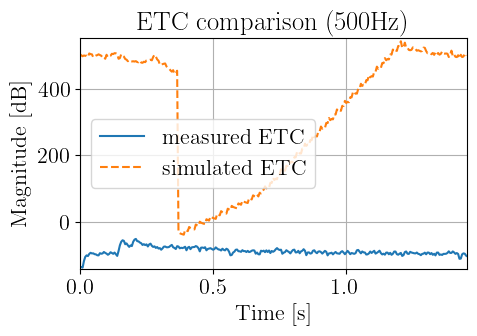

In [60]:
figure,ax = plt.subplots(figsize=(5,3))
pf.plot.time(signal=etc_measurement,dB=True,log_prefix=10, ax=ax)
pf.plot.time(signal=etc_radiosity[0],dB=True,log_prefix=10, ax=ax,
             linestyle='--')
plt.grid()
plt.title(f"ETC comparison ({freqcy}Hz)")
plt.legend(["measured ETC","simulated ETC"])

ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Time [s]')

#figure.savefig('D:\\Joao_Fatela\\phd\\Papers\\Internoise_2025\\figures\\ETCs_vs.pdf',bbox_inches='tight')

In [61]:
%load_ext watermark
%watermark -v -m -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.1.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

numpy     : 1.26.4
pyfar     : 0.7.3
debugpy   : 1.8.14
ipykernel : 6.29.5
sparrowpy : 0.1.0
matplotlib: 3.10.1

